## Playground for exponential regularizer

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
import gzip
import pickle
import os
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [5]:
batch_size = 64
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
def print_stats(model_p, sparsity=1e-4):
    params = torch.cat([param.view(-1) for param in list(model_p.parameters())])
    params_n = params.detach().numpy()
    N = params_n.size
    stats = {}
    print("Mean")
    stats['mean'] = np.mean(np.abs(params_n))
    print(stats['mean'])
    print("standard deviation")
    stats['std'] = np.sqrt(np.var(np.abs(params_n)))
    print(stats['std'])
    print("Sparsity")
    print(np.sum(np.abs(params_n)<sparsity)/N)

In [7]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

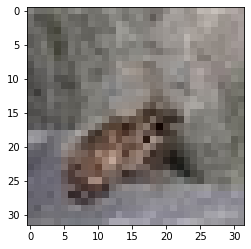

Sample label for this image: frog


In [8]:
for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    imshow(inputs[0])
    print("Sample label for this image: " + str(classes[labels[0].numpy()]))
    break

In [9]:
def get_model_error(model_t):
    tot_num = 0.0
    num_wrong = 0.0
    dataiter = iter(testloader)
    for images,labels in dataiter:
        outputs = model_t(images)
        for image, label, i in zip(images, labels, range(len(images))):
    #         imshow(image)
    #         print(model(image).detach().numpy())
    #         expected_class = classes[outputs[i].detach().numpy().argmax()]
            expected_class_i = int(outputs[i].detach().numpy().argmax())
    #         print("Predicted class: %s" % expected_class)
    #         print("expected: " + str(int(label)))
            tot_num+=1
            if int(label) != expected_class_i:
                num_wrong+=1
    error = num_wrong/tot_num
    print("test error: " + str(error))
    return error
    

In [10]:
## Define the loss function to be used
ce_loss = nn.CrossEntropyLoss(reduction='sum')
def criterion(op, y):
    params = list(model.parameters())
    return ce_loss(op, y) #+ (1/len(params))*(torch.norm(torch.cat([param.view(-1) for param in params]))) #+ torch.sum((1/len(params))*torch.exp(torch.abs(torch.cat([param.view(-1) for param in params]))))


In [80]:
model = nn.Sequential(
    nn.Conv2d(3, 16, 3),
    nn.FractionalMaxPool2d(2, output_ratio=(1/np.sqrt(2))),
    nn.Conv2d(16, 32, 3),
    nn.FractionalMaxPool2d(2, output_ratio=(1/np.sqrt(2))),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(1152, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)
alpha = 0.1
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer_adam = optim.Adam(list(model.parameters()), lr=0.001)
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer_adam.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_adam.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0


KeyboardInterrupt: 

In [11]:
## Define the loss function to be used
def criterion_p(op, y, model_p):
    params = list(model_p.parameters())
    return ce_loss(op, y) + (1/len(params))*(torch.norm(torch.cat([param.view(-1) for param in params]))) #+ torch.sum((1/len(params))*torch.exp(torch.abs(torch.cat([param.view(-1) for param in params]))))

In [14]:
# model trained on the new regularizer
model_new = nn.Sequential(
    nn.Conv2d(3, 32, 3),
    nn.FractionalMaxPool2d(2, output_ratio=(1/np.sqrt(2))),
    nn.Conv2d(32, 64, 3),
    nn.FractionalMaxPool2d(2, output_ratio=(1/np.sqrt(2))),
    nn.Flatten(),
    nn.Linear(10816, 16188),
    nn.ReLU(),
    nn.Linear(16188, 5408),
    nn.ReLU(),
    nn.Linear(5408, 1152),
    nn.ReLU(),
    nn.Linear(1152, 512),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

In [15]:
alpha = 0.1
optimizer_new = optim.SGD(model_new.parameters(), lr=1e-4, momentum=0.9, weight_decay = 1/len(list(model_new.parameters())))
# optimizer_old = optim.SGD(model_new.parameters(), lr=0.01, momentum=0.9, weight_decay = 1/len(list(model_new.parameters())))
optimizer_adam_new = optim.Adam(list(model_new.parameters()), lr=3e-4)
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer_adam_new.zero_grad()

        # forward + backward + optimize
        outputs = model_new(inputs)
        loss = criterion_p(outputs, labels, model_new)
        loss.backward()
        optimizer_adam_new.step()

        # print statistics
#         running_loss += loss.item()
        if i % 300 ==299:    # print every 2000 mini-batches
#             print('[%d, %5d] running_loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 2000))
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, loss.item()))
#             running_loss = 0.0
    print('loss for epoch %d: %.3f' % (epoch+1, loss.item()))

Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/abdulhannan/anaconda3/envs/playground/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/abdulhannan/anaconda3/envs/playground/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/abdulhannan/anaconda3/envs/playground/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/abdulhannan/anaconda3/envs/playground/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/Users/abdulhannan/anaconda3/envs/playground/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/abdulhannan/anaconda3/envs/playground/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[off

KeyboardInterrupt: 

In [87]:
err_n = get_model_error(model_new)
save_model(model_new, filename="./cifar_20e_norm_n.pth")

test error: 0.3027


### errors: 
- base - test error: 0.3309
- norm/n resularizer - 0.3027


In [26]:
#save model
def save_model(model_save, filename="./cifar_net.pth"):
    torch.save(model_save.state_dict(), filename)
#load model
def load_model(file, model):
    model.load_state_dict(torch.load(file))

In [29]:

dataiter = iter(testloader)
images, labels = dataiter.next()

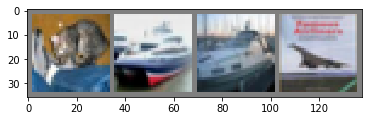

In [52]:

# print images
imshow(torchvision.utils.make_grid(images))

In [30]:
outputs = model_new(images)

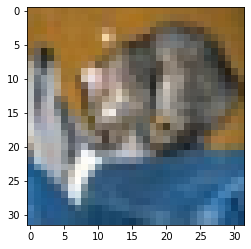

cat


In [31]:
imshow(images[0])
# print("predicted class: " + str(classes[outputs[0]]))
print(classes[outputs[0].detach().numpy().argmax()])

In [65]:
# analysis of model params
# ! pip install scipy
print_stats(model_new, sparsity=1e-4)
# print("mean: " + np.mean([param.view(-1) for param in params]))
model_newer = model_new

Mean
0.014815067
standard deviation
0.011969818
Sparsity
0.004412533114307208


In [72]:
print_stats(model_new, sparsity=1e-4)

Mean
0.013458797
standard deviation
0.011134833
Sparsity
0.010480527728399868


## Values for model with 10 epochs of training
- model params Conv2d -FracMaxPool - BatchNorm2d -  conv2d - FracMaxPool - linear - relu - bn - linear - relu- CELoss.   
- exp regularizer used:  $(1/n)\exp(|x|)$ where $n$ is the number of model parameters.  

### Test error with the above regularizer: 

- Test error: $0.5732$

### Test error without regularizer:
- test error: $0.5625$

### Test error with wight decay with $\alpha=1$
- test error: $0.9$ (???)